In [1]:
import requests
import pandas as pd

cad_url = "https://ssd-api.jpl.nasa.gov/cad.api"
params = {
    "dist-max": "0.05",
    "date-min": "2025-01-01",
    "date-max": "2026-12-31",
    "sort": "date",
    "body": "Earth",
    "limit": 10000,
    "fullname": "true"
}
cad_data = requests.get(cad_url, params=params).json()
cols = cad_data["fields"]
df = pd.DataFrame(cad_data["data"], columns=cols)
# Now get more details for each asteroid
details = []
for des in df["des"].head(10000):  # limit to 10 for speed
    sbdb_url = f"https://ssd-api.jpl.nasa.gov/sbdb.api?sstr={des}"
    detail = requests.get(sbdb_url).json()
    info = {
        "des": des,
        "diameter": detail.get("phys_par", {}).get("diameter"),
        "orbit_class": detail.get("orbit_class", {}).get("name"),
        "pha": detail.get("pha"),
    }
    details.append(info)

extra_df = pd.DataFrame(details)
df = df.merge(extra_df, on="des", how="left")
print(len(df))




1425


In [ ]:
# renaming the columns fro understanding
rename_map = {
    "des": "Asteroid ID",
    "orbit_id": "Orbit Number",
    "jd": "Julian Date",
    "cd": "Close Approach Date",
    "dist": "Distance from Earth (AU)",
    "dist_min": "Minimum Distance (AU)",
    "dist_max": "Maximum Distance (AU)",
    "v_rel": "Relative Velocity (km/s)",
    "v_inf": "Velocity w/o Gravity (km/s)",
    "t_sigma_f": "Timing Uncertainty (days)",
    "h": "Absolute Magnitude (H)",
    "fullname": "Asteroid Name",
    "diameter": "Estimated Diameter (km)",
    "orbit_class": "Orbit Type",
    "pha": "Potentially Hazardous (Y/N)"
}

df = df.rename(columns=rename_map)


In [ ]:
# Claening
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

In [2]:
 #Handle missing values

df = df.copy()
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
# type casting
df['Orbit Number'] = pd.to_numeric(df['Orbit Number'], errors='coerce').astype('Int64')
df['Julian Date'] = pd.to_numeric(df['Julian Date'], errors='coerce')
df['Close Approach Date'] = pd.to_datetime(df['Close Approach Date'], errors='coerce')


In [ ]:
# Handle outliers (IQR method) ********** thsi part is Optional
import numpy as np
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return np.clip(series, lower, upper)

for col in num_cols:
    df[col] = cap_outliers(df[col])

In [ ]:
#Cleaning the strings
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip().str.title()

In [ ]:
# Converting the txt to boo so that it is easy for ML to understand
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
if 'Potentially Hazardous' in df.columns:
    df['Potentially Hazardous'] = df['Potentially Hazardous'].map({
        'True': 1, 'Yes': 1, 'Y': 1,
        'False': 0, 'No': 0, 'N': 0
    }).fillna(0).astype(int)

if 'Orbit Type' in df.columns:
    le = LabelEncoder()
    df['Orbit Type'] = le.fit_transform(df['Orbit Type'])

In [ ]:
# Scaling it for ML  ****** this one is Importat for model to  treats all features fairly
if len(num_cols) > 0:
    scaler = MinMaxScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
# Ensure the columns are numeric
for col in ['Estimated Diameter (km)', 'Relative Velocity (km/s)', 'Distance from Earth (AU)']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Now compute the Risk_Score
if all(col in df.columns for col in ['Estimated Diameter (km)', 'Relative Velocity (km/s)', 'Distance from Earth (AU)']):
    df['Risk_Score'] = (
        df['Estimated Diameter (km)'] *
        df['Relative Velocity (km/s)'] /
        (df['Distance from Earth (AU)'] + 1e-6)
    )


In [ ]:
# EDA from this part apart

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import normaltest, shapiro
import warnings
warnings.filterwarnings('ignore')

In [9]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)
colors = sns.color_palette("husl", 12)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [12]:
def print_section_header(title, char="="):
    """Print formatted section headers"""
    print(f"\n{char * 100}")
    print(f"{title:^100}")
    print(f"{char * 100}\n")

def print_subsection(title):
    """Print formatted subsection headers"""
    print(f"\n{'─' * 100}")
    print(f"➤ {title}")
    print(f"{'─' * 100}")

def create_styled_table(data, title=""):
    """Create beautifully formatted tables"""
    if title:
        print(f"\n {title}")
    print(data.to_string())


In [13]:
print_section_header(" ASTEROID DATASET - COMPREHENSIVE EXPLORATORY DATA ANALYSIS ")

print(f"""
{'EXECUTIVE SUMMARY':^100}
{'─' * 100}
Dataset Dimensions        : {df.shape[0]:,} observations × {df.shape[1]} features
Memory Footprint         : {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB
Analysis Date            : {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Data Completeness        : {(1 - df.isnull().sum().sum()/(df.shape[0]*df.shape[1]))*100:.2f}%
{'─' * 100}
""")


                     ASTEROID DATASET - COMPREHENSIVE EXPLORATORY DATA ANALYSIS                     


                                         EXECUTIVE SUMMARY                                          
────────────────────────────────────────────────────────────────────────────────────────────────────
Dataset Dimensions        : 1,425 observations × 15 features
Memory Footprint         : 1.11 MB
Analysis Date            : 2025-10-04 11:35:50
Data Completeness        : 80.00%
────────────────────────────────────────────────────────────────────────────────────────────────────



In [28]:

print_section_header(" DATA STRUCTURE & INFORMATION", "=")

print_subsection("Column Information")
info_df = pd.DataFrame({
    'Column': df.columns,
    'Data_Type': df.dtypes.values,
    'Non_Null_Count': df.notnull().sum().values,
    'Null_Count': df.isnull().sum().values,
    'Null_Percentage': (df.isnull().sum().values / len(df) * 100).round(2),
    'Unique_Values': [df[col].nunique() for col in df.columns],
    'Memory_MB': (df.memory_usage(deep=True).values[1:] / 1024**2).round(3)
})
create_styled_table(info_df, "Column-wise Data Summary")



                                    DATA STRUCTURE & INFORMATION                                    


────────────────────────────────────────────────────────────────────────────────────────────────────
➤ Column Information
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Column-wise Data Summary
                         Column Data_Type  Non_Null_Count  Null_Count  Null_Percentage  Unique_Values  Memory_MB
0                   Asteroid ID    object            1425           0              0.0           1362      0.077
1                  Orbit Number    object            1425           0              0.0             66      0.068
2                   Julian Date    object            1425           0              0.0           1383      0.090
3           Close Approach Date    object            1425           0              0.0           1381      0.090
4      Distance from Earth (AU)   float64            1425           0           

In [27]:
print_section_header(" ADVANCED STATISTICAL ANALYSIS", "=")

numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

print_subsection("Comprehensive Descriptive Statistics")
desc_stats = df[numeric_features].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
desc_stats['variance'] = df[numeric_features].var()
desc_stats['skewness'] = df[numeric_features].skew()
desc_stats['kurtosis'] = df[numeric_features].kurtosis()
# Coefficient of Variation - handle division by zero and infinity
desc_stats['cv'] = np.where(
    (desc_stats['mean'].abs() > 1e-10) & np.isfinite(desc_stats['mean']) & np.isfinite(desc_stats['std']),
    (desc_stats['std'] / desc_stats['mean'].abs() * 100).round(2),
    np.nan
)
create_styled_table(desc_stats, "Extended Statistical Summary")

# Normality tests
print_subsection("Normality Test Results (Shapiro-Wilk)")
normality_results = []
for col in numeric_features:
    try:
        data_clean = df[col].dropna()
        # Remove infinite values
        data_clean = data_clean[np.isfinite(data_clean)]

        if len(data_clean) > 3 and len(data_clean.unique()) > 1:
            # Limit to 5000 samples for performance
            sample_data = data_clean.sample(min(5000, len(data_clean)), random_state=42)
            stat, p_value = shapiro(sample_data)
            normality_results.append({
                'Feature': col,
                'Statistic': f"{stat:.4f}",
                'P_Value': f"{p_value:.4e}",
                'Normal': '✓ Yes' if p_value > 0.05 else '✗ No',
                'Sample_Size': len(sample_data)
            })
    except Exception as e:
        print(f"⚠ Warning: Could not compute normality test for {col}: {str(e)}")

if normality_results:
    create_styled_table(pd.DataFrame(normality_results), "Normality Assessment")


                                    ADVANCED STATISTICAL ANALYSIS                                   


────────────────────────────────────────────────────────────────────────────────────────────────────
➤ Comprehensive Descriptive Statistics
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Extended Statistical Summary
                              count       mean       std        min         1%         5%        25%        50%        75%        95%        99%        max   variance  skewness   kurtosis     cv
Distance from Earth (AU)     1425.0   0.021611  0.014692   0.000045   0.000497   0.001528   0.008353   0.020164   0.034091   0.046438   0.049420   0.049992   0.000216  0.264302  -1.180714  67.98
Minimum Distance (AU)        1425.0   0.020562  0.014357   0.000045   0.000448   0.001358   0.007642   0.018479   0.032523   0.045399   0.049118   0.049991   0.000206  0.332236  -1.117287  69.83
Maximum Distance (AU)        1425.0   


                                       MISSING VALUE ANALYSIS                                       


📊 Missing Values Summary
                                                  Column  Missing_Count  Missing_Percentage Data_Type
Timing Uncertainty (days)      Timing Uncertainty (days)           1425               100.0   float64
Estimated Diameter (km)          Estimated Diameter (km)           1425               100.0   float64
Orbit Type                                    Orbit Type           1425               100.0   float64
Potentially Hazardous (Y/N)  Potentially Hazardous (Y/N)           1425               100.0   float64


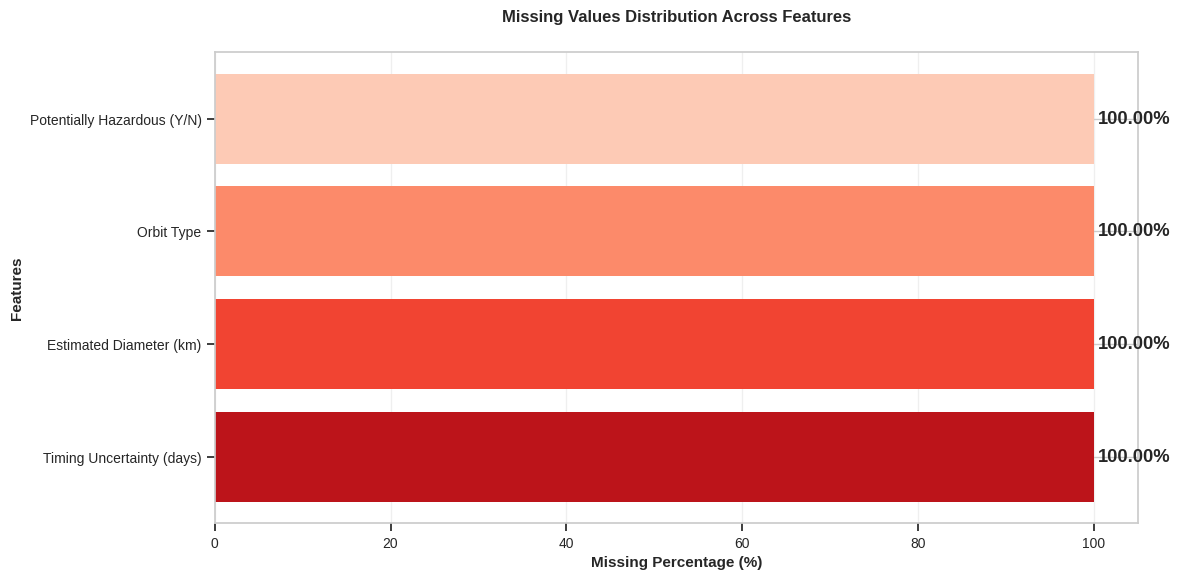

In [30]:
print_section_header(" MISSING VALUE ANALYSIS", "=")

missing_analysis = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(3),
    'Data_Type': df.dtypes
})
missing_analysis = missing_analysis[missing_analysis['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
)

if len(missing_analysis) > 0:
    create_styled_table(missing_analysis, "Missing Values Summary")

    # Visualize missing values
    plt.figure(figsize=(12, 6))
    missing_cols = missing_analysis['Column'].tolist()
    missing_pcts = missing_analysis['Missing_Percentage'].tolist()

    bars = plt.barh(missing_cols, missing_pcts, color=sns.color_palette("Reds_r", len(missing_cols)))
    plt.xlabel('Missing Percentage (%)', fontweight='bold')
    plt.ylabel('Features', fontweight='bold')
    plt.title('Missing Values Distribution Across Features', fontsize=12, fontweight='bold', pad=22)
    plt.grid(axis='x', alpha=0.3)

    for i, (col, pct) in enumerate(zip(missing_cols, missing_pcts)):
        plt.text(pct + 0.5, i, f'{pct:.2f}%', va='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('01_missing_values_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print(" EXCELLENT: No missing values detected in the dataset")



                                 UNIVARIATE ANALYSIS - DISTRIBUTIONS                                



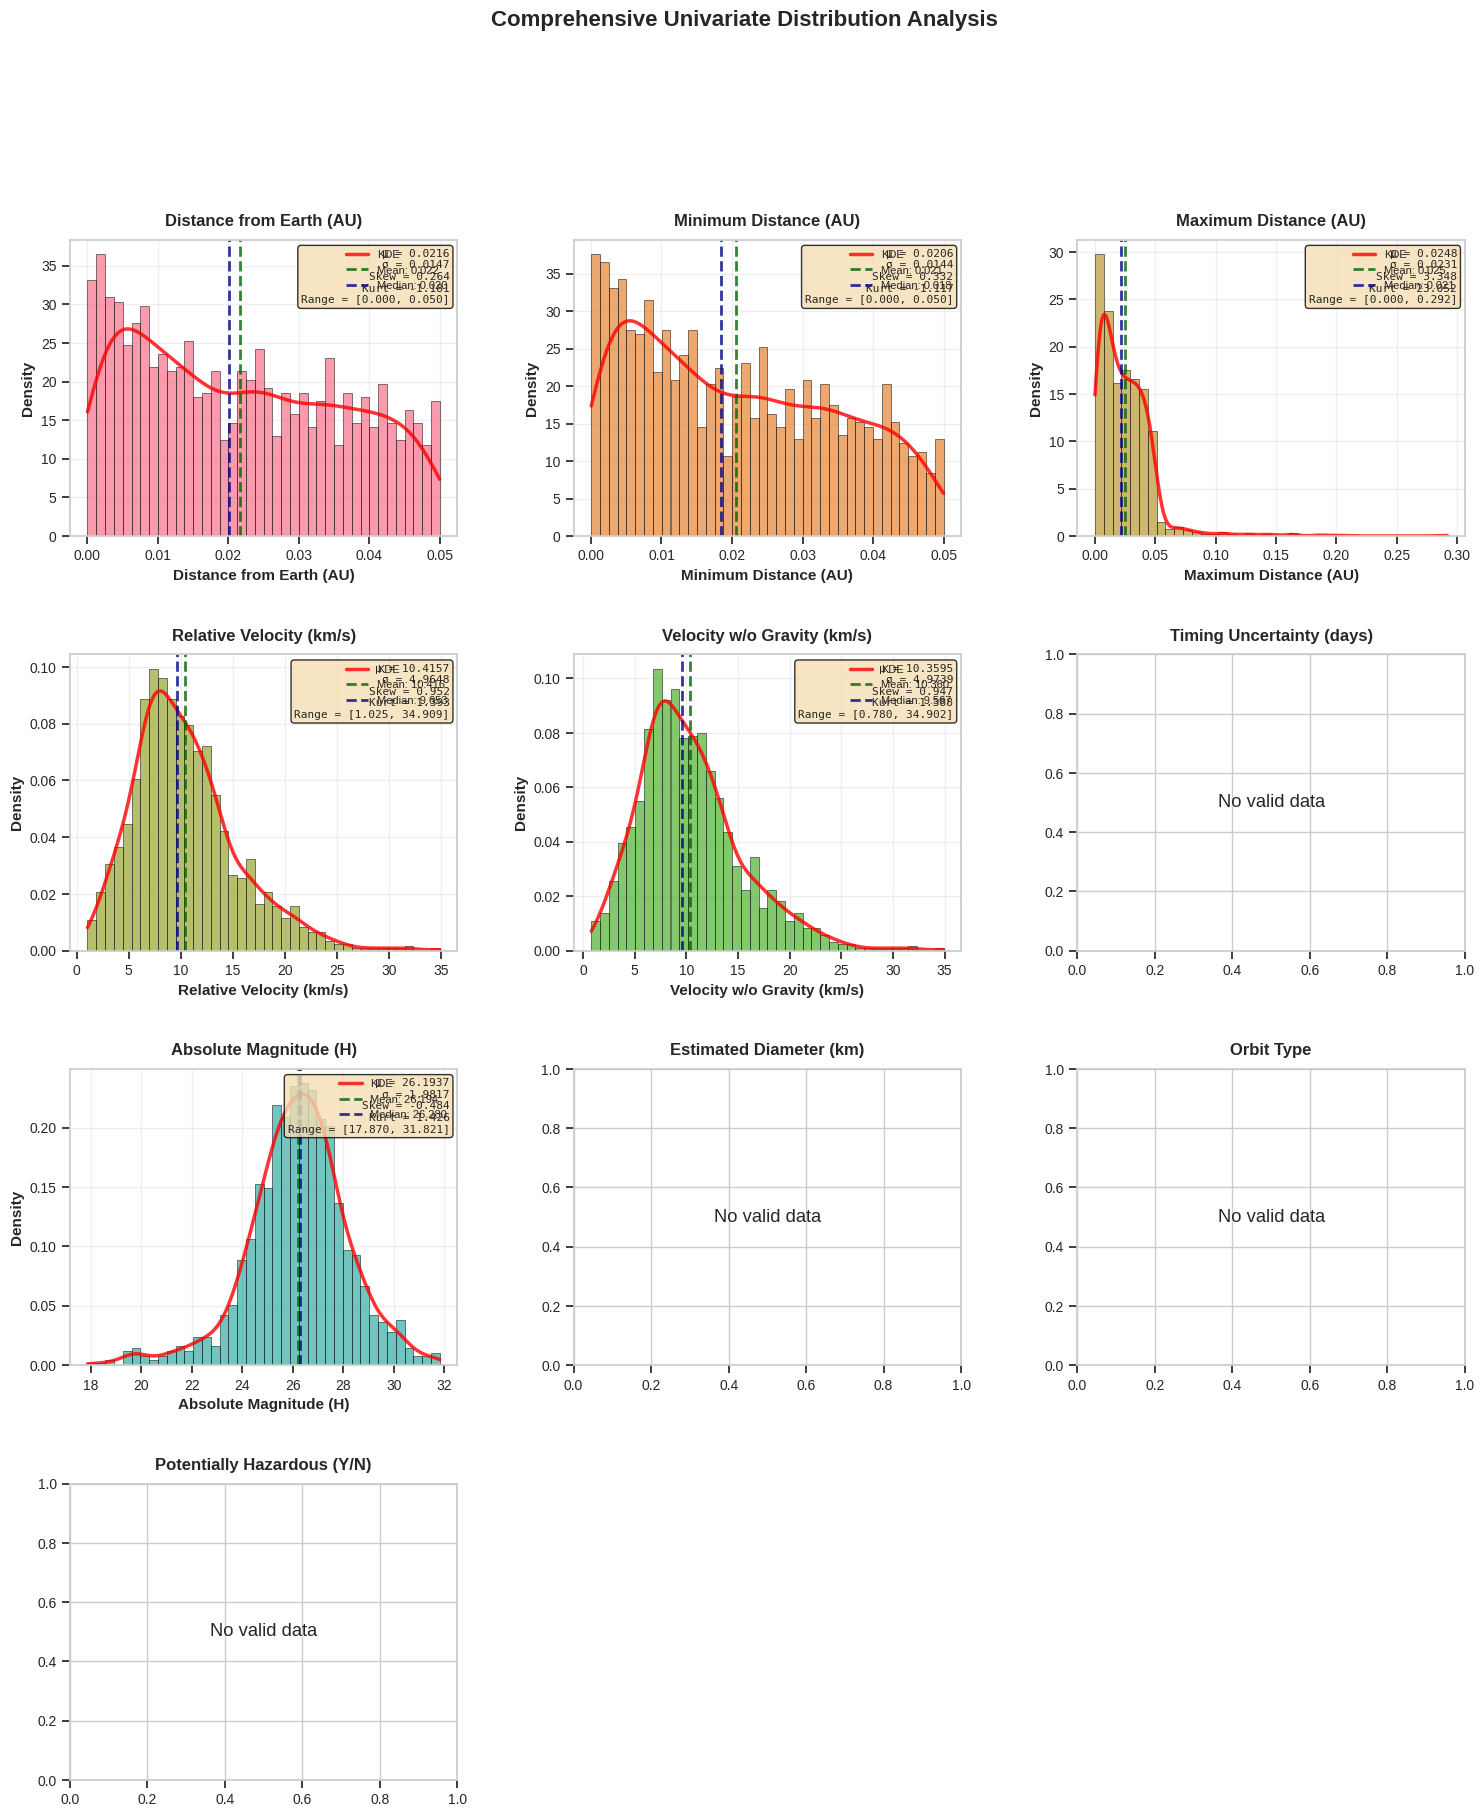

In [31]:
print_section_header(" UNIVARIATE ANALYSIS - DISTRIBUTIONS", "=")

# Create comprehensive distribution plots
n_features = len(numeric_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig = plt.figure(figsize=(18, n_rows * 5))
gs = fig.add_gridspec(n_rows, n_cols, hspace=0.4, wspace=0.3)

for idx, col in enumerate(numeric_features):
    row = idx // n_cols
    col_pos = idx % n_cols

    # Create 2x2 subplot for each feature
    ax_main = fig.add_subplot(gs[row, col_pos])

    data = df[col].dropna()
    # Remove infinite values
    data = data[np.isfinite(data)]

    if len(data) == 0:
        ax_main.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax_main.transAxes)
        ax_main.set_title(f'{col}', fontsize=12, fontweight='bold', pad=10)
        continue

    # Histogram with KDE
    try:
        n, bins, patches = ax_main.hist(data, bins=min(40, len(data)//10 if len(data) > 100 else 10),
                                         alpha=0.7, color=colors[idx % len(colors)],
                                         edgecolor='black', linewidth=0.5, density=True)

        # Add KDE
        if len(data) > 1 and data.std() > 0:
            kde_x = np.linspace(data.min(), data.max(), 200)
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(data)
            ax_main.plot(kde_x, kde(kde_x), 'r-', linewidth=2.5, label='KDE', alpha=0.8)

        # Add mean and median lines
        mean_val = data.mean()
        median_val = data.median()
        ax_main.axvline(mean_val, color='darkgreen', linestyle='--', linewidth=2,
                       label=f'Mean: {mean_val:.3f}', alpha=0.8)
        ax_main.axvline(median_val, color='darkblue', linestyle='--', linewidth=2,
                       label=f'Median: {median_val:.3f}', alpha=0.8)

        ax_main.set_title(f'{col}', fontsize=12, fontweight='bold', pad=10)
        ax_main.set_xlabel(col, fontweight='bold')
        ax_main.set_ylabel('Density', fontweight='bold')
        ax_main.legend(loc='upper right', fontsize=8)
        ax_main.grid(True, alpha=0.3)

        # Statistics box
        stats_text = (f"μ = {data.mean():.4f}\n"
                      f"σ = {data.std():.4f}\n"
                      f"Skew = {data.skew():.3f}\n"
                      f"Kurt = {data.kurtosis():.3f}\n"
                      f"Range = [{data.min():.3f}, {data.max():.3f}]")

        ax_main.text(0.98, 0.97, stats_text, transform=ax_main.transAxes,
                     verticalalignment='top', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black'),
                     fontsize=8, family='monospace')
    except Exception as e:
        ax_main.text(0.5, 0.5, f'Error plotting: {str(e)[:30]}', ha='center', va='center',
                    transform=ax_main.transAxes, fontsize=8)

plt.suptitle('Comprehensive Univariate Distribution Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.savefig('02_univariate_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


                                   🎯 OUTLIER DETECTION & ANALYSIS                                   


📊 Outlier Detection Summary (IQR Method)
                       Feature  Mild_Outliers Mild_Outliers_%  Extreme_Outliers Extreme_Outliers_% Lower_Fence Upper_Fence
0     Distance from Earth (AU)              0           0.00%                 0              0.00%     -0.0303      0.0727
1        Minimum Distance (AU)              0           0.00%                 0              0.00%     -0.0297      0.0698
2        Maximum Distance (AU)             33           2.32%                14              0.98%     -0.0330      0.0776
3     Relative Velocity (km/s)             39           2.74%                 4              0.28%     -1.9266     21.8522
4  Velocity w/o Gravity (km/s)             39           2.74%                 4              0.28%     -1.9930     21.8650
5       Absolute Magnitude (H)             54           3.79%                 1              0.07%     21.7150     30

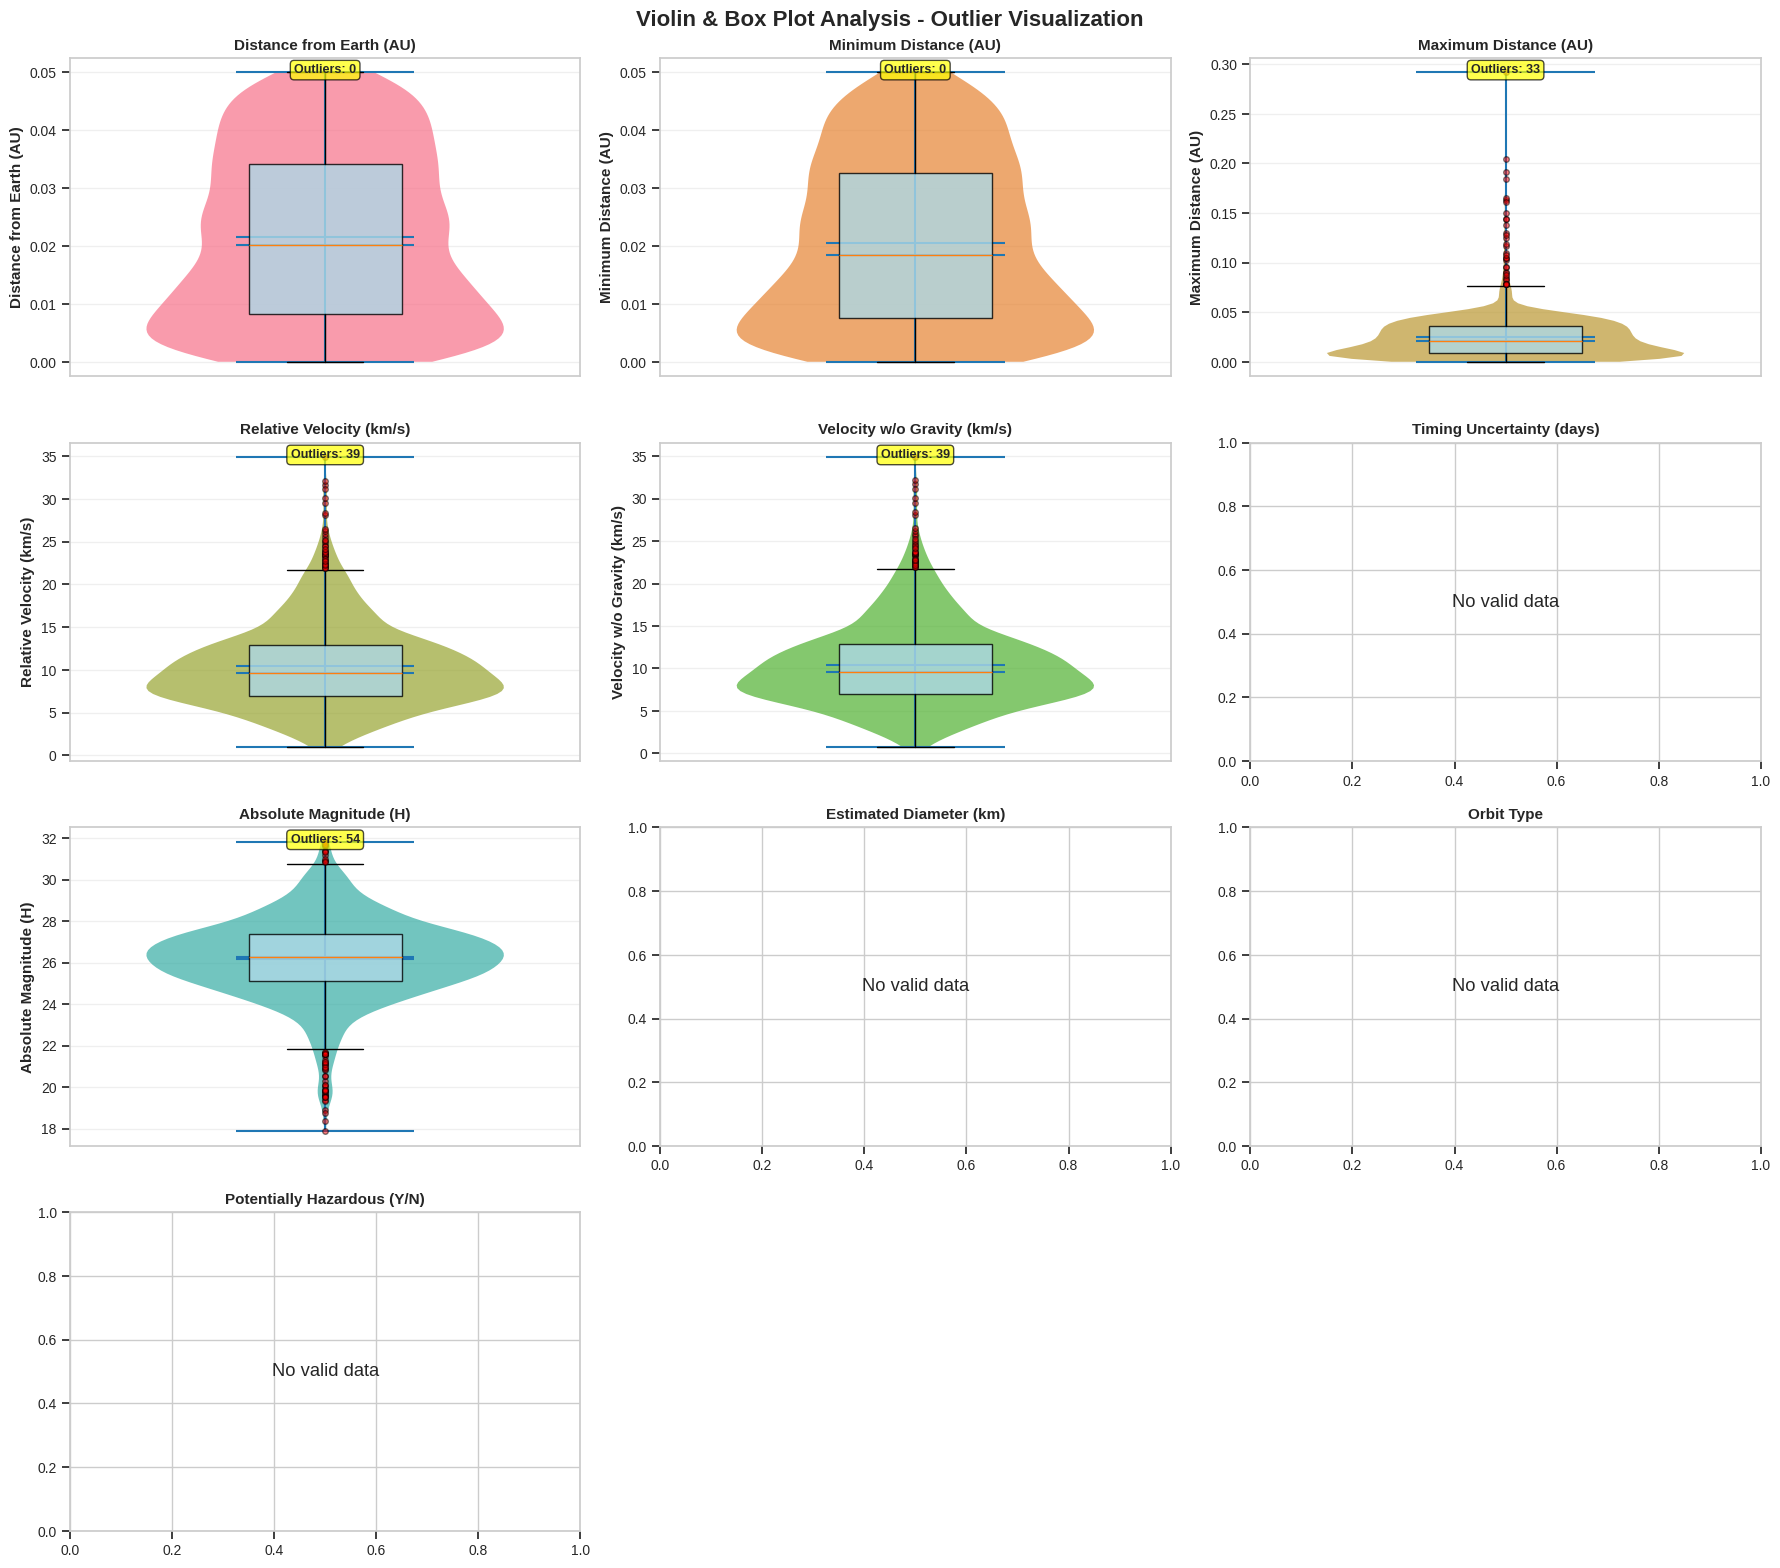

In [32]:
print_section_header(" OUTLIER DETECTION & ANALYSIS", "=")

outlier_summary = []
for col in numeric_features:
    try:
        data_clean = df[col].dropna()
        # Remove infinite values
        data_clean = data_clean[np.isfinite(data_clean)]

        if len(data_clean) == 0:
            continue

        Q1 = data_clean.quantile(0.25)
        Q3 = data_clean.quantile(0.75)
        IQR = Q3 - Q1

        if IQR == 0:
            # All values are the same, skip outlier detection
            outlier_summary.append({
                'Feature': col,
                'Mild_Outliers': 0,
                'Mild_Outliers_%': '0.00%',
                'Extreme_Outliers': 0,
                'Extreme_Outliers_%': '0.00%',
                'Lower_Fence': f"{Q1:.4f}",
                'Upper_Fence': f"{Q3:.4f}",
                'Note': 'No variance'
            })
            continue

        lower_fence = Q1 - 1.5 * IQR
        upper_fence = Q3 + 1.5 * IQR

        # Extreme outliers (3*IQR)
        extreme_lower = Q1 - 3 * IQR
        extreme_upper = Q3 + 3 * IQR

        mild_outliers = data_clean[(data_clean < lower_fence) | (data_clean > upper_fence)]
        extreme_outliers = data_clean[(data_clean < extreme_lower) | (data_clean > extreme_upper)]

        outlier_summary.append({
            'Feature': col,
            'Mild_Outliers': len(mild_outliers),
            'Mild_Outliers_%': f"{(len(mild_outliers)/len(data_clean)*100):.2f}%",
            'Extreme_Outliers': len(extreme_outliers),
            'Extreme_Outliers_%': f"{(len(extreme_outliers)/len(data_clean)*100):.2f}%",
            'Lower_Fence': f"{lower_fence:.4f}",
            'Upper_Fence': f"{upper_fence:.4f}"
        })
    except Exception as e:
        print(f"⚠ Warning: Could not compute outliers for {col}: {str(e)}")

outlier_df = pd.DataFrame(outlier_summary)
create_styled_table(outlier_df, "Outlier Detection Summary (IQR Method)")

# Enhanced box plots with violin plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, col in enumerate(numeric_features):
    ax = axes[idx]
    try:
        data_clean = df[col].dropna()
        # Remove infinite values
        data_clean = data_clean[np.isfinite(data_clean)]

        if len(data_clean) == 0:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{col}', fontsize=11, fontweight='bold')
            continue

        # Violin plot with box plot overlay
        parts = ax.violinplot([data_clean.values], positions=[0], widths=0.7,
                              showmeans=True, showextrema=True, showmedians=True)

        for pc in parts['bodies']:
            pc.set_facecolor(colors[idx % len(colors)])
            pc.set_alpha(0.7)

        # Overlay box plot
        bp = ax.boxplot([data_clean.values], positions=[0], widths=0.3,
                         patch_artist=True, showfliers=True,
                         flierprops=dict(marker='o', markerfacecolor='red', markersize=4, alpha=0.5))

        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.8)

        ax.set_title(f'{col}', fontsize=11, fontweight='bold')
        ax.set_ylabel(col, fontweight='bold')
        ax.set_xticks([])
        ax.grid(True, alpha=0.3, axis='y')

        # Add outlier count
        Q1, Q3 = data_clean.quantile([0.25, 0.75])
        IQR = Q3 - Q1
        if IQR > 0:
            outlier_count = ((data_clean < Q1 - 1.5*IQR) | (data_clean > Q3 + 1.5*IQR)).sum()
            ax.text(0.5, 0.98, f'Outliers: {outlier_count}', transform=ax.transAxes,
                    ha='center', va='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                    fontsize=9, fontweight='bold')
    except Exception as e:
        ax.text(0.5, 0.5, f'Error: {str(e)[:20]}', ha='center', va='center',
               transform=ax.transAxes, fontsize=8)

for idx in range(n_features, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Violin & Box Plot Analysis - Outlier Visualization', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('03_outlier_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


                              CORRELATION & MULTICOLLINEARITY ANALYSIS                              



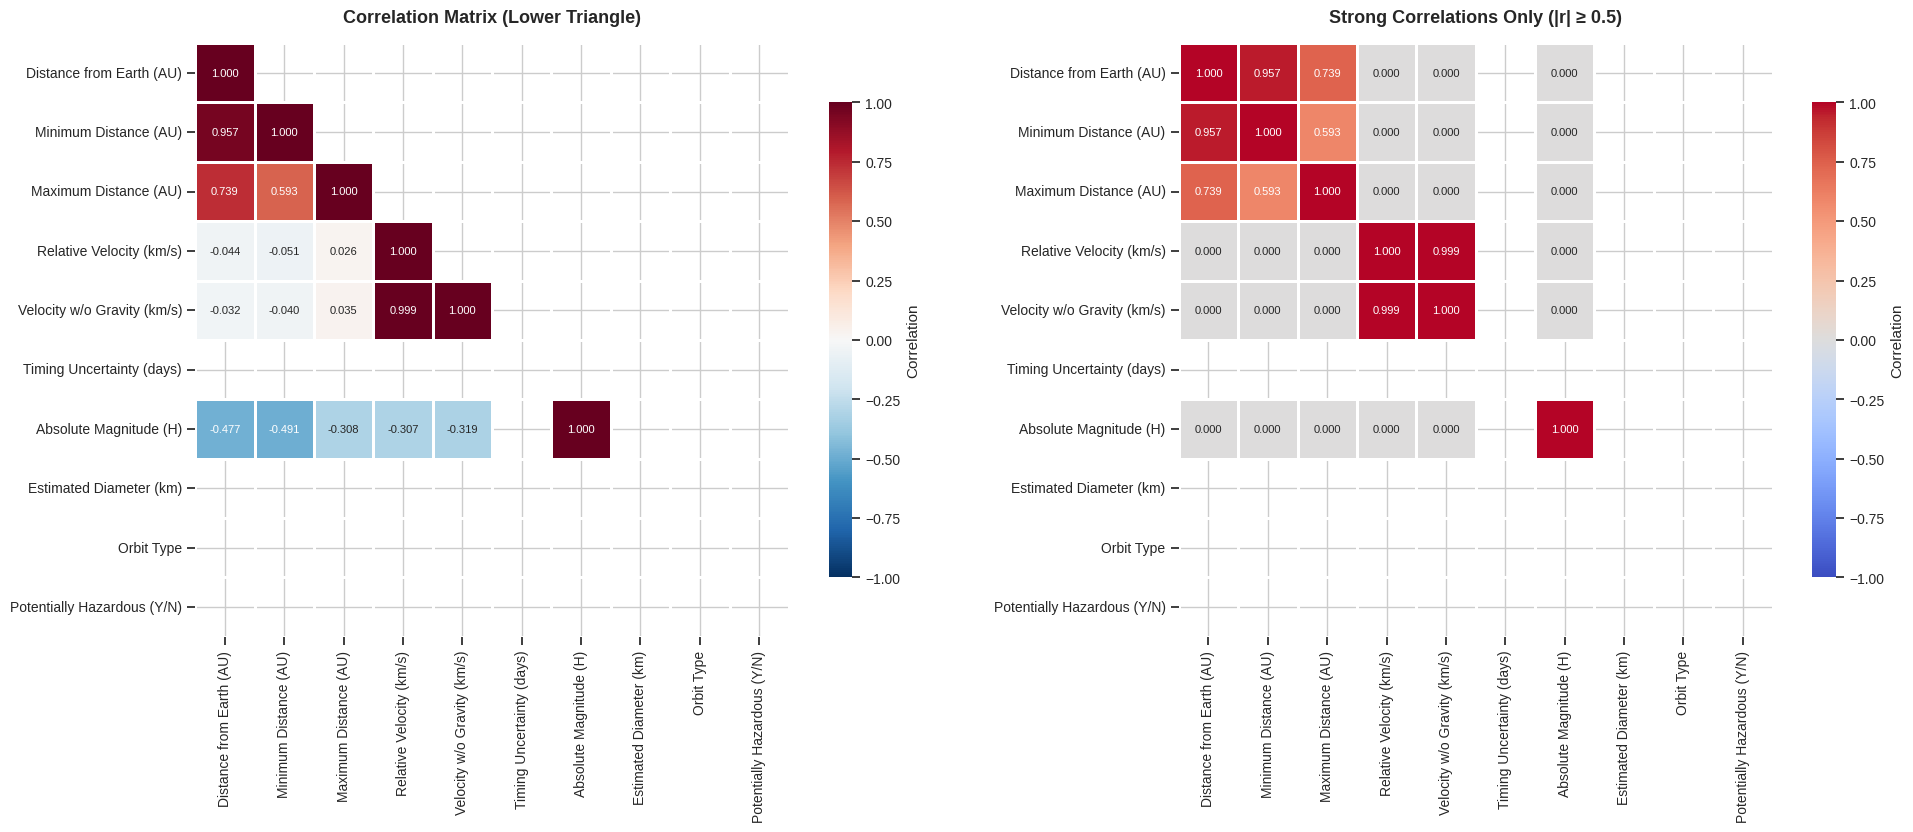


────────────────────────────────────────────────────────────────────────────────────────────────────
➤ Correlation Strength Classification
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Significant Correlation Pairs
                     Feature_1                    Feature_2 Correlation Abs_Correlation     Strength      Type
6     Relative Velocity (km/s)  Velocity w/o Gravity (km/s)      0.9993          0.9993  Very Strong  Positive
0     Distance from Earth (AU)        Minimum Distance (AU)      0.9567          0.9567  Very Strong  Positive
1     Distance from Earth (AU)        Maximum Distance (AU)      0.7386          0.7386       Strong  Positive
3        Minimum Distance (AU)        Maximum Distance (AU)      0.5926          0.5926     Moderate  Positive
4        Minimum Distance (AU)       Absolute Magnitude (H)     -0.4909          0.4909         Weak  Negative
2     Distance from Earth (AU)       Absolute Magnitude (H) 

In [34]:
print_section_header("CORRELATION & MULTICOLLINEARITY ANALYSIS", "=")

corr_matrix = df[numeric_features].corr()

# Create an enhanced correlation heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Full correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8, "label": "Correlation"},
            vmin=-1, vmax=1, ax=ax1, annot_kws={'size': 8})
ax1.set_title('Correlation Matrix (Lower Triangle)', fontsize=13, fontweight='bold', pad=15)

# High correlation only
high_corr_matrix = corr_matrix.copy()
high_corr_matrix[abs(high_corr_matrix) < 0.5] = 0
sns.heatmap(high_corr_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8, "label": "Correlation"},
            vmin=-1, vmax=1, ax=ax2, annot_kws={'size': 8})
ax2.set_title('Strong Correlations Only (|r| ≥ 0.5)', fontsize=13, fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('04_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation pairs analysis
print_subsection("Correlation Strength Classification")
correlation_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        abs_corr = abs(corr_val)

        if abs_corr > 0.3:  # Show moderate and above
            if abs_corr >= 0.9:
                strength = "Very Strong"
            elif abs_corr >= 0.7:
                strength = "Strong"
            elif abs_corr >= 0.5:
                strength = "Moderate"
            else:
                strength = "Weak"

            correlation_pairs.append({
                'Feature_1': corr_matrix.columns[i],
                'Feature_2': corr_matrix.columns[j],
                'Correlation': f"{corr_val:.4f}",
                'Abs_Correlation': f"{abs_corr:.4f}",
                'Strength': strength,
                'Type': 'Positive' if corr_val > 0 else 'Negative'
            })

if correlation_pairs:
    corr_df = pd.DataFrame(correlation_pairs).sort_values('Abs_Correlation', ascending=False)
    create_styled_table(corr_df, "Significant Correlation Pairs")



                                 MULTIVARIATE RELATIONSHIP ANALYSIS                                 

Generating pairplot for top 6 features by variance...


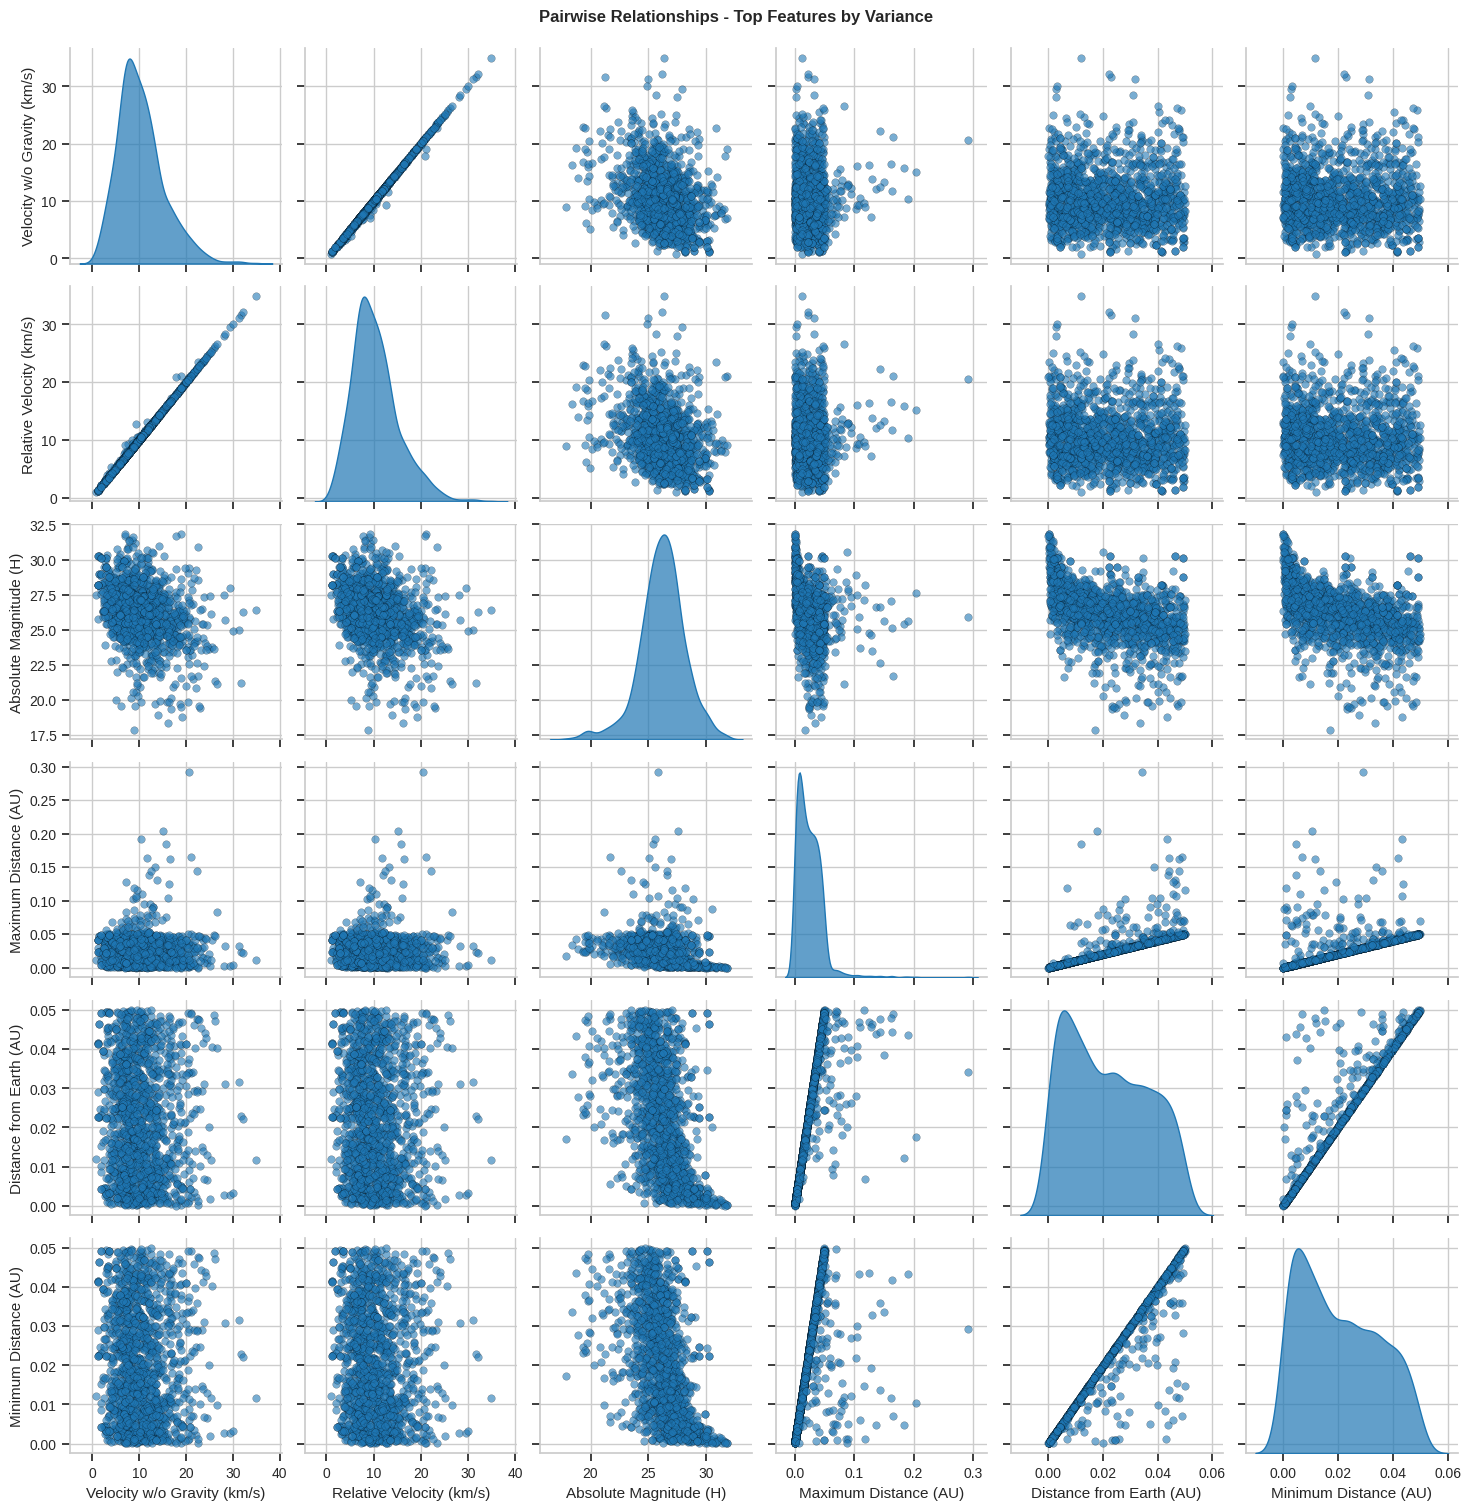

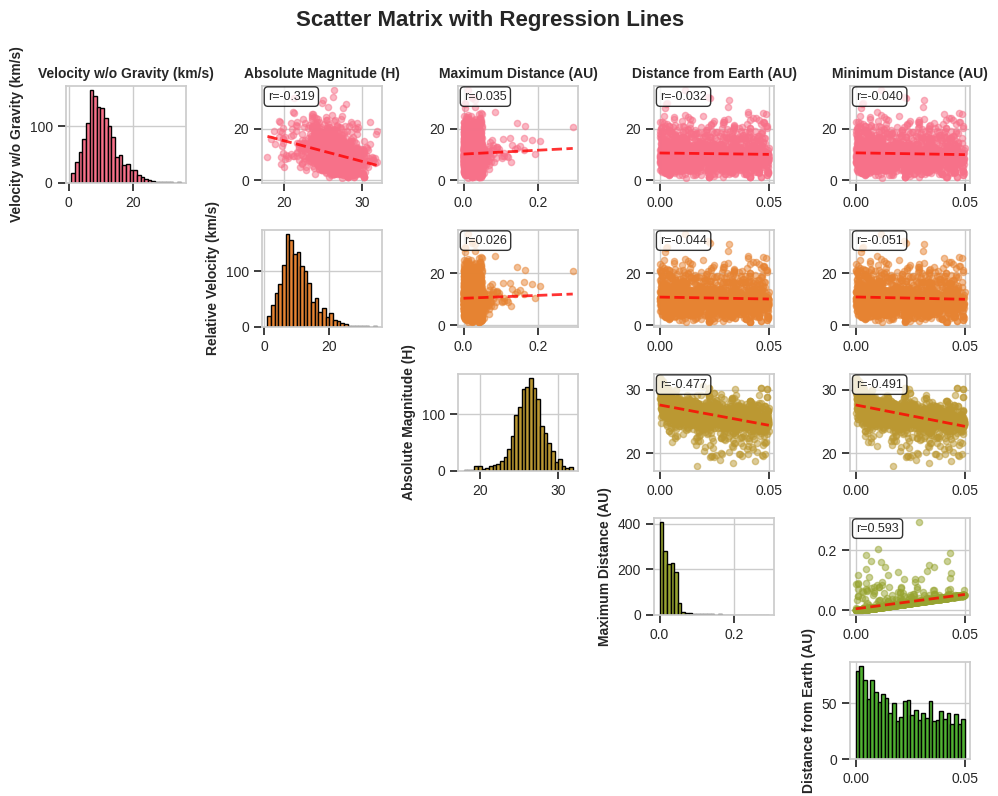

In [42]:
print_section_header(" MULTIVARIATE RELATIONSHIP ANALYSIS", "=")

# Select top features by variance for pairplot
top_variance_features = df[numeric_features].var().nlargest(min(6, len(numeric_features))).index.tolist()

if len(top_variance_features) >= 2:
    print(f"Generating pairplot for top {len(top_variance_features)} features by variance...")

    pairplot_data = df[top_variance_features].copy()

    g = sns.pairplot(pairplot_data,
                     diag_kind='kde',
                     plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'black', 'linewidth': 0.2},
                     diag_kws={'alpha': 0.7, 'linewidth': 1})

    g.fig.suptitle('Pairwise Relationships - Top Features by Variance',
                   fontsize=12, fontweight='bold', y=1.01)

    plt.savefig('05_pairplot_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Scatter matrix with regression lines
if len(top_variance_features) >= 2:
    from scipy.stats import pearsonr

    fig, axes = plt.subplots(len(top_variance_features)-1, len(top_variance_features)-1,
                             figsize=(10, 8))

    for i in range(len(top_variance_features)-1):
        for j in range(len(top_variance_features)-1):
            ax = axes[i, j] if len(top_variance_features) > 2 else axes

            if j < i:
                ax.axis('off')
            elif j == i:
                df[top_variance_features[i]].hist(bins=30, ax=ax, color=colors[i], edgecolor='black')
                ax.set_ylabel('')
            else:
                ax.scatter(df[top_variance_features[j+1]], df[top_variance_features[i]],
                          alpha=0.5, s=20, c=colors[i])

                # Add regression line
                z = np.polyfit(df[top_variance_features[j+1]].dropna(),
                              df[top_variance_features[i]].dropna(), 1)
                p = np.poly1d(z)
                ax.plot(df[top_variance_features[j+1]].sort_values(),
                       p(df[top_variance_features[j+1]].sort_values()),
                       "r--", linewidth=2, alpha=0.8)

                # Calculate correlation
                valid_data = df[[top_variance_features[j+1], top_variance_features[i]]].dropna()
                if len(valid_data) > 0:
                    r, p_val = pearsonr(valid_data.iloc[:, 0], valid_data.iloc[:, 1])
                    ax.text(0.05, 0.95, f'r={r:.3f}', transform=ax.transAxes,
                           fontsize=9, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            if i == 0:
                ax.set_title(top_variance_features[j+1] if j != i else top_variance_features[i],
                            fontsize=10, fontweight='bold')
            if j == 0 or (j == i and i > 0):
                ax.set_ylabel(top_variance_features[i], fontsize=10, fontweight='bold')

    plt.suptitle('Scatter Matrix with Regression Lines', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('06_scatter_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


                                    CATEGORICAL FEATURE ANALYSIS                                    


────────────────────────────────────────────────────────────────────────────────────────────────────
➤ Analysis of: Asteroid ID
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Top Categories in Asteroid ID
     Category  Count  Percentage
0    2025 HQ4      4        0.28
1   2025 FY11      4        0.28
2     2020 GE      4        0.28
3     2025 DQ      4        0.28
4    2022 OB5      4        0.28
5     2025 BL      4        0.28
6     2025 SC      4        0.28
7    2025 DU7      4        0.28
8    2025 PN7      4        0.28
9    2025 QM9      4        0.28
10   2025 KR4      4        0.28
11   2025 RQ2      4        0.28
12  2025 SP20      4        0.28
13    2025 CC      4        0.28
14    2025 OW      4        0.28


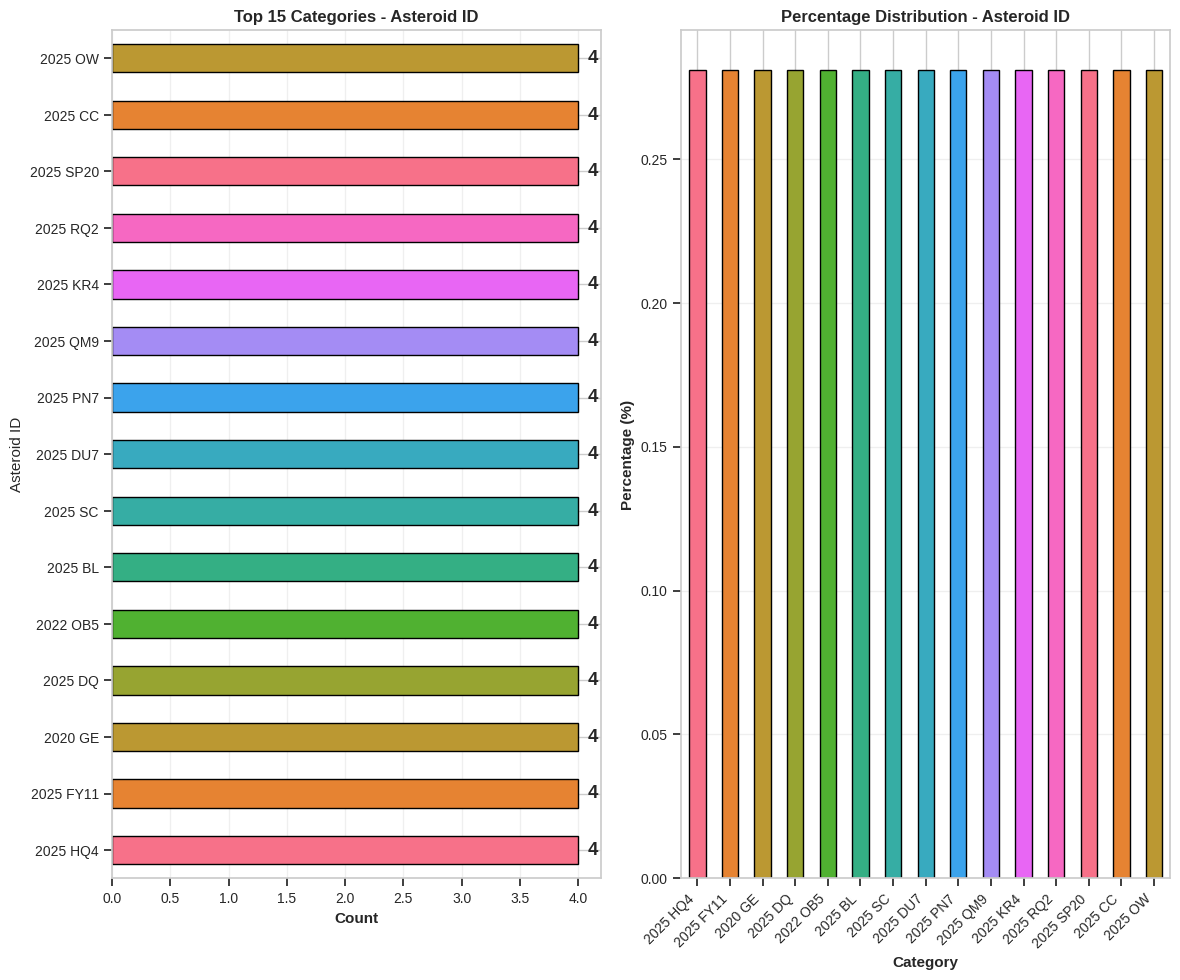


────────────────────────────────────────────────────────────────────────────────────────────────────
➤ Analysis of: Orbit Number
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Top Categories in Orbit Number
   Category  Count  Percentage
0         2    228       16.00
1         1    217       15.23
2         3    211       14.81
3         4    171       12.00
4         5    116        8.14
5         6     98        6.88
6         7     59        4.14
7         8     49        3.44
8         9     36        2.53
9        11     33        2.32
10       10     30        2.11
11       13     24        1.68
12       12     20        1.40
13       15     12        0.84
14       14     11        0.77


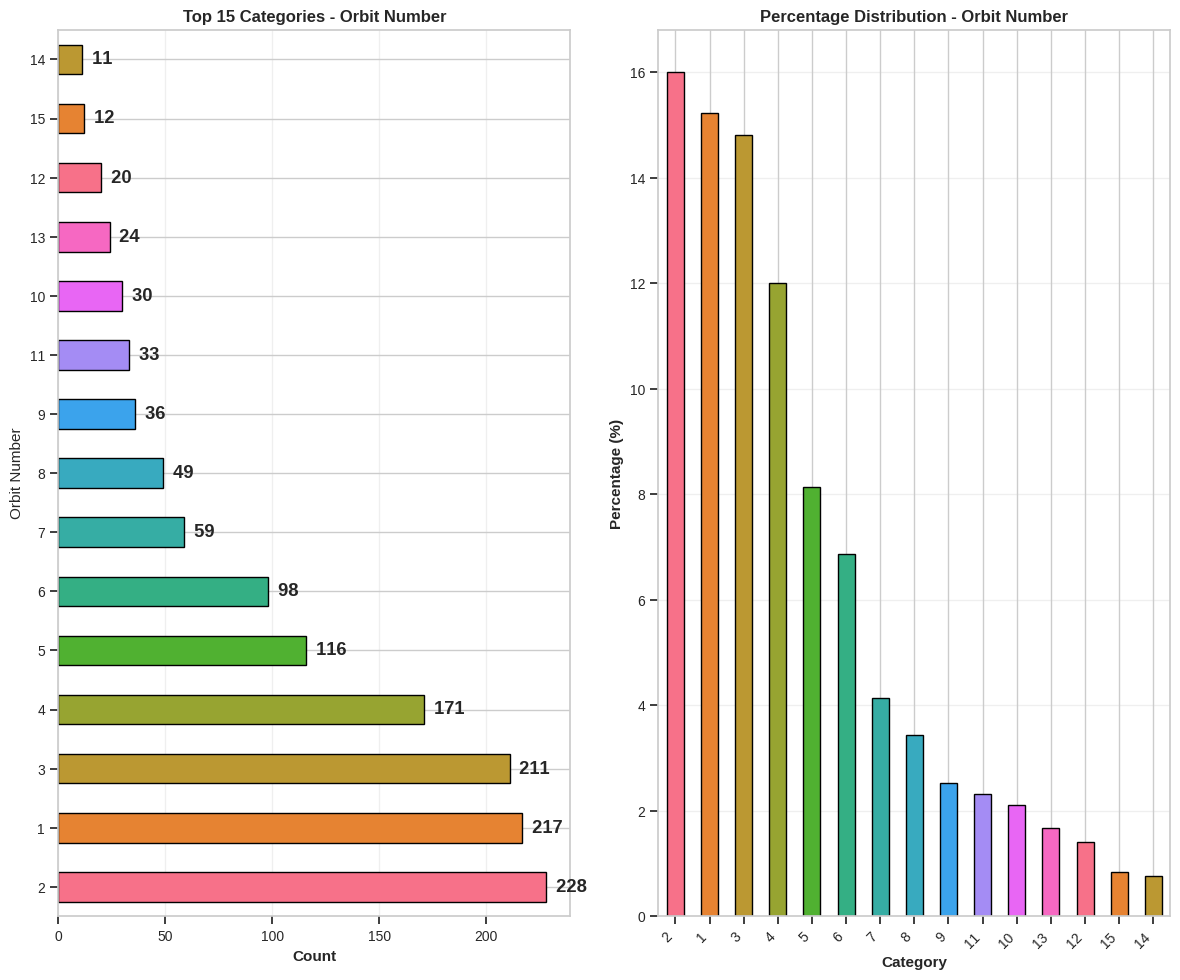


────────────────────────────────────────────────────────────────────────────────────────────────────
➤ Analysis of: Julian Date
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Top Categories in Julian Date
             Category  Count  Percentage
0   2460793.921231887      2        0.14
1   2460885.322282515      2        0.14
2   2460947.971903125      2        0.14
3   2460914.900209414      2        0.14
4   2460761.381890034      2        0.14
5   2461285.991297864      2        0.14
6   2461125.171886040      2        0.14
7   2461284.683269255      2        0.14
8   2461133.568949039      2        0.14
9   2461281.079302568      2        0.14
10  2461272.501234943      2        0.14
11  2460931.185308265      2        0.14
12  2460712.009797038      2        0.14
13  2460767.632926519      2        0.14
14  2461152.124783406      2        0.14


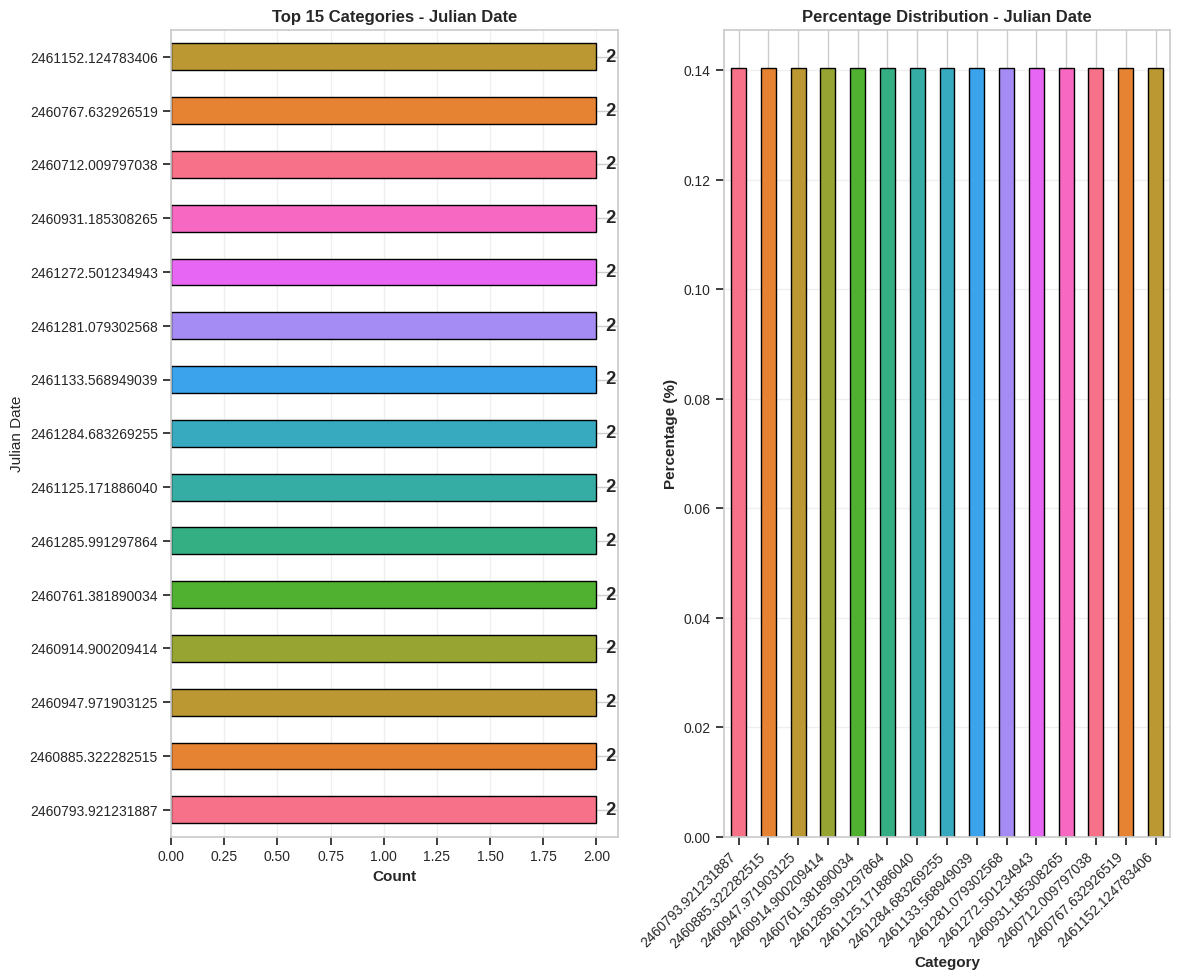


────────────────────────────────────────────────────────────────────────────────────────────────────
➤ Analysis of: Close Approach Date
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Top Categories in Close Approach Date
             Category  Count  Percentage
0   2026-Sep-02 11:47      2        0.14
1   2026-Sep-01 04:24      2        0.14
2   2026-Aug-28 13:54      2        0.14
3   2026-Aug-20 00:02      2        0.14
4   2026-Aug-19 21:34      2        0.14
5   2025-Feb-05 12:14      2        0.14
6   2026-Jul-30 06:08      2        0.14
7   2026-Jul-17 21:09      2        0.14
8   2025-May-15 10:14      2        0.14
9   2025-Jan-16 23:57      2        0.14
10  2025-Aug-27 09:36      2        0.14
11  2025-Sep-18 03:41      2        0.14
12  2026-May-18 01:17      2        0.14
13  2025-Jan-18 01:44      2        0.14
14  2025-Feb-06 17:03      2        0.14


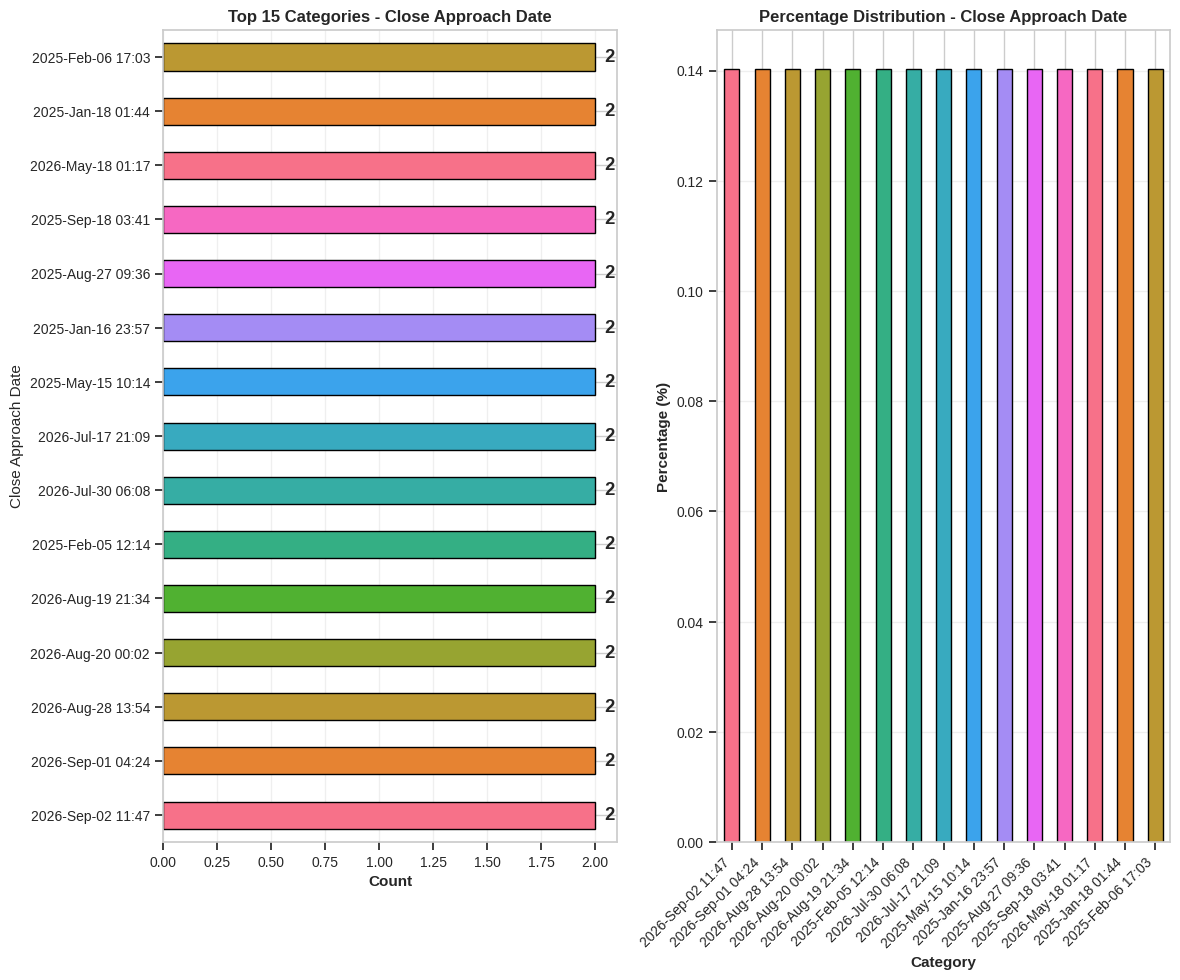


────────────────────────────────────────────────────────────────────────────────────────────────────
➤ Analysis of: Asteroid Name
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Top Categories in Asteroid Name
              Category  Count  Percentage
0           (2025 HQ4)      4        0.28
1          (2025 FY11)      4        0.28
2            (2020 GE)      4        0.28
3            (2025 DQ)      4        0.28
4           (2022 OB5)      4        0.28
5            (2025 BL)      4        0.28
6            (2025 SC)      4        0.28
7           (2025 DU7)      4        0.28
8           (2025 PN7)      4        0.28
9           (2025 QM9)      4        0.28
10          (2025 KR4)      4        0.28
11          (2025 RQ2)      4        0.28
12         (2025 SP20)      4        0.28
13           (2025 CC)      4        0.28
14           (2025 OW)      4        0.28


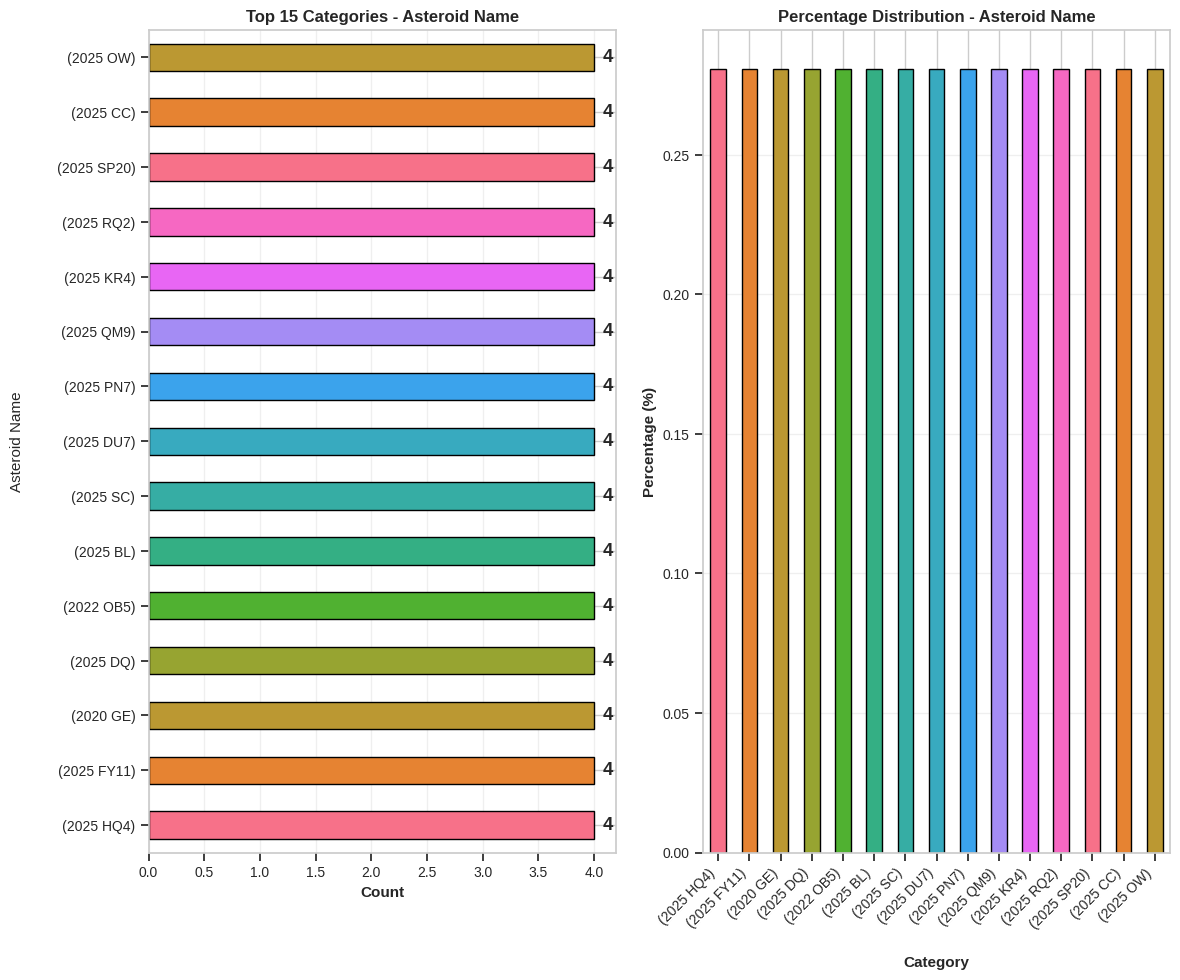

In [39]:
if len(categorical_features) > 0:
    print_section_header(" CATEGORICAL FEATURE ANALYSIS", "=")

    for cat_col in categorical_features:
        print_subsection(f"Analysis of: {cat_col}")

        value_counts = df[cat_col].value_counts()
        value_props = df[cat_col].value_counts(normalize=True) * 100

        cat_summary = pd.DataFrame({
            'Category': value_counts.index,
            'Count': value_counts.values,
            'Percentage': value_props.values.round(2)
        })
        create_styled_table(cat_summary.head(15), f"Top Categories in {cat_col}")

        # Visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 10))

        # Bar plot
        top_n = min(15, len(value_counts))
        value_counts.head(top_n).plot(kind='barh', ax=ax1, color=colors[:top_n], edgecolor='black')
        ax1.set_xlabel('Count', fontweight='bold')
        ax1.set_title(f'Top {top_n} Categories - {cat_col}', fontweight='bold', fontsize=12)
        ax1.grid(axis='x', alpha=0.3)

        for i, v in enumerate(value_counts.head(top_n).values):
            ax1.text(v + max(value_counts) * 0.01, i, f' {v:,}', va='center', fontweight='bold')

        # Pie chart
        if top_n <= 10:
            value_counts.head(top_n).plot(kind='pie', ax=ax2, autopct='%1.1f%%',
                                         colors=colors[:top_n], startangle=90)
            ax2.set_ylabel('')
            ax2.set_title(f'Distribution - {cat_col}', fontweight='bold', fontsize=12)
        else:
            # Too many categories for pie, use another bar
            value_props.head(top_n).plot(kind='bar', ax=ax2, color=colors[:top_n], edgecolor='black')
            ax2.set_xlabel('Category', fontweight='bold')
            ax2.set_ylabel('Percentage (%)', fontweight='bold')
            ax2.set_title(f'Percentage Distribution - {cat_col}', fontweight='bold', fontsize=12)
            ax2.grid(axis='y', alpha=0.3)
            plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

        plt.tight_layout()
        plt.savefig(f'07_categorical_{cat_col.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.show()



                                         TEMPORAL ANALYSIS                                          


📊 Monthly Temporal Statistics
                     Count  Avg_Distance  Min_Distance  Max_Distance  Avg_Velocity  Std_Velocity
Close Approach Date                                                                             
2025-01                140      0.021419      0.000065      0.049422     10.427832      5.134495
2025-02                155      0.019757      0.000819      0.048399     10.646879      5.482615
2025-03                182      0.019526      0.000147      0.049793     11.247895      5.511032
2025-04                141      0.021501      0.000186      0.049992     10.467566      4.618083
2025-05                 91      0.020475      0.000770      0.049489     10.471269      5.157618
2025-06                 75      0.019018      0.000468      0.048457     10.566449      5.022406
2025-07                 95      0.021363      0.000070      0.049593     10.482682      5.

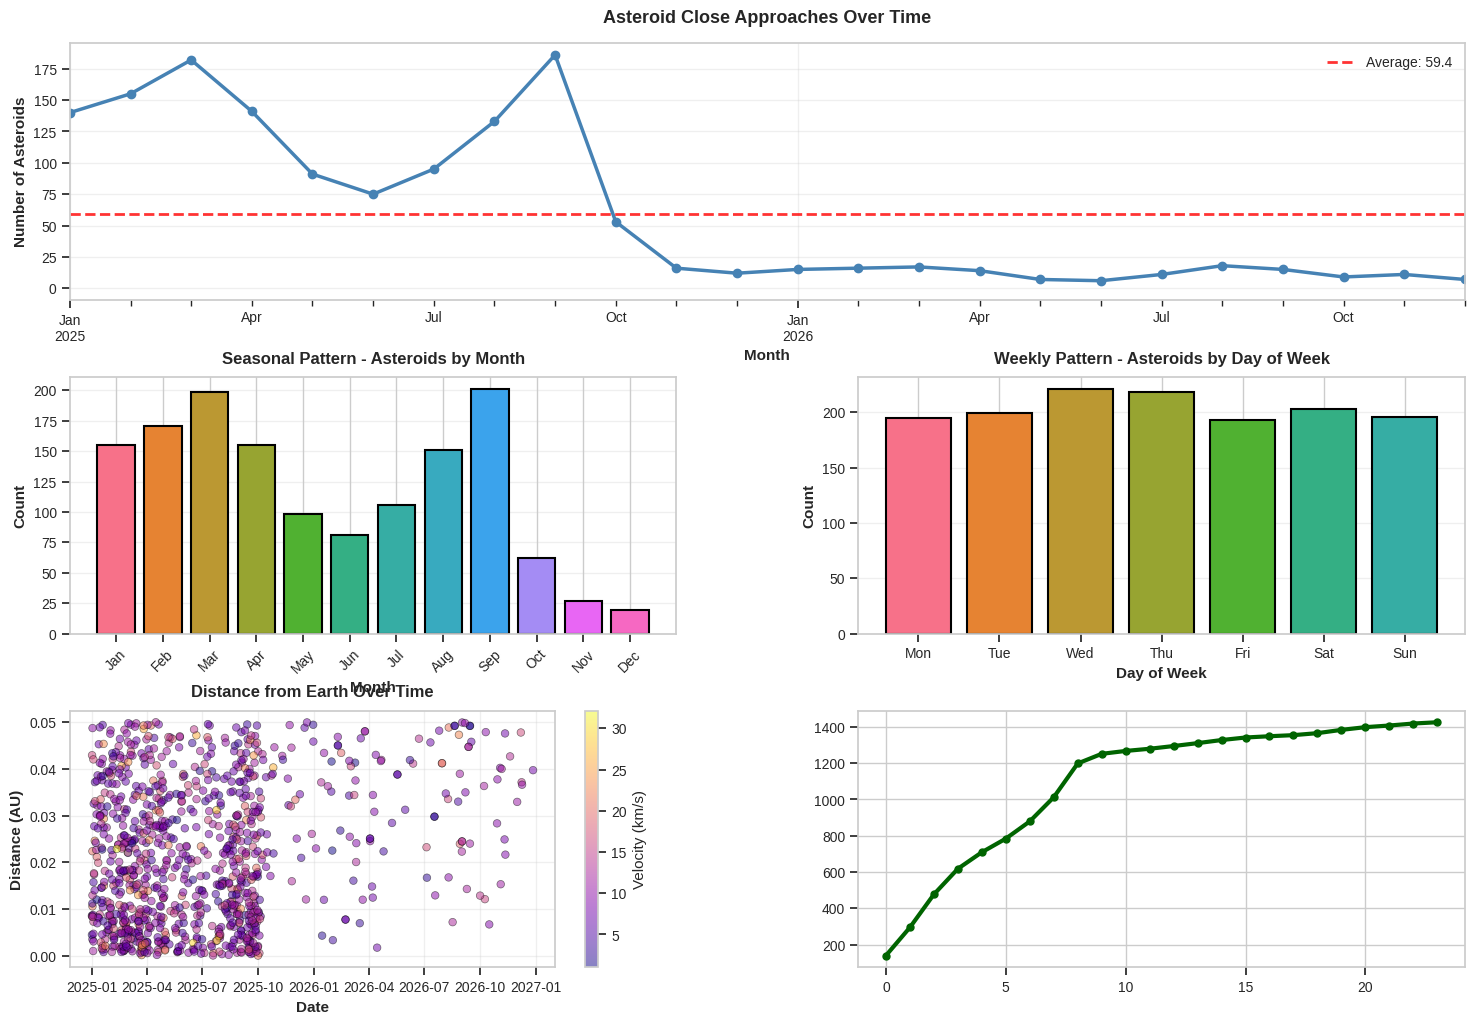

In [43]:
if 'Close Approach Date' in df.columns:
    print_section_header("TEMPORAL ANALYSIS", "=")

    df_time = df.copy()
    df_time['Close Approach Date'] = pd.to_datetime(df_time['Close Approach Date'], errors='coerce')
    df_time = df_time.dropna(subset=['Close Approach Date']).sort_values('Close Approach Date')

    # Extract temporal features
    df_time['Year'] = df_time['Close Approach Date'].dt.year
    df_time['Month'] = df_time['Close Approach Date'].dt.month
    df_time['Quarter'] = df_time['Close Approach Date'].dt.quarter
    df_time['Day_of_Week'] = df_time['Close Approach Date'].dt.dayofweek
    df_time['Week'] = df_time['Close Approach Date'].dt.isocalendar().week

    # Monthly trends
    monthly_stats = df_time.groupby(df_time['Close Approach Date'].dt.to_period('M')).agg({
        'Asteroid ID': 'count',
        'Distance from Earth (AU)': ['mean', 'min', 'max'],
        'Relative Velocity (km/s)': ['mean', 'std']
    })

    monthly_stats.columns = ['Count', 'Avg_Distance', 'Min_Distance', 'Max_Distance', 'Avg_Velocity', 'Std_Velocity']
    create_styled_table(monthly_stats.head(12), "Monthly Temporal Statistics")

    # Comprehensive time series visualization
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

    # 1. Time series of asteroid counts
    ax1 = fig.add_subplot(gs[0, :])
    monthly_counts = df_time.groupby(df_time['Close Approach Date'].dt.to_period('M')).size()
    monthly_counts.plot(kind='line', ax=ax1, color='steelblue', linewidth=2.5, marker='o', markersize=6)
    ax1.fill_between(range(len(monthly_counts)), monthly_counts.values, alpha=0.3, color='steelblue')
    ax1.set_title('Asteroid Close Approaches Over Time', fontsize=13, fontweight='bold', pad=15)
    ax1.set_xlabel('Month', fontweight='bold')
    ax1.set_ylabel('Number of Asteroids', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(monthly_counts.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Average: {monthly_counts.mean():.1f}', alpha=0.8)
    ax1.legend(fontsize=10)

    # 2. Seasonal pattern
    ax2 = fig.add_subplot(gs[1, 0])
    month_counts = df_time.groupby('Month').size()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax2.bar(range(1, 13), month_counts.reindex(range(1, 13), fill_value=0),
            color=colors[:12], edgecolor='black', linewidth=1.5)
    ax2.set_xticks(range(1, 13))
    ax2.set_xticklabels(month_names, rotation=45)
    ax2.set_title('Seasonal Pattern - Asteroids by Month', fontsize=12, fontweight='bold', pad=10)
    ax2.set_xlabel('Month', fontweight='bold')
    ax2.set_ylabel('Count', fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)

    # 3. Day of week pattern
    ax3 = fig.add_subplot(gs[1, 1])
    dow_counts = df_time.groupby('Day_of_Week').size()
    dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    ax3.bar(range(7), dow_counts.reindex(range(7), fill_value=0),
            color=colors[:7], edgecolor='black', linewidth=1.5)
    ax3.set_xticks(range(7))
    ax3.set_xticklabels(dow_names)
    ax3.set_title('Weekly Pattern - Asteroids by Day of Week', fontsize=12, fontweight='bold', pad=10)
    ax3.set_xlabel('Day of Week', fontweight='bold')
    ax3.set_ylabel('Count', fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)

    # 4. Distance over time
    ax4 = fig.add_subplot(gs[2, 0])
    df_time_sample = df_time.sample(min(1000, len(df_time)))
    ax4.scatter(df_time_sample['Close Approach Date'], df_time_sample['Distance from Earth (AU)'],
                alpha=0.5, s=30, c=df_time_sample['Relative Velocity (km/s)'], cmap='plasma', edgecolors='black', linewidth=0.5)
    ax4.set_title('Distance from Earth Over Time', fontsize=12, fontweight='bold', pad=10)
    ax4.set_xlabel('Date', fontweight='bold')
    ax4.set_ylabel('Distance (AU)', fontweight='bold')
    ax4.grid(True, alpha=0.3)
    plt.colorbar(ax4.collections[0], ax=ax4, label='Velocity (km/s)')

    # 5. Cumulative count
    ax5 = fig.add_subplot(gs[2, 1])
    cumulative = monthly_counts.cumsum()
    ax5.plot(range(len(cumulative)), cumulative.values, color='darkgreen', linewidth=3, marker='o', markersize=5)
    ax5.fill